In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import opensmile
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
import io
from PIL import Image
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import random

In [2]:
# FROM https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/GANs/ProGAN

def seed_everything(seed=4):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(4)

In [3]:
SUMMARY_TABLE_PATH = "./CREMA-D/processedResults/summaryTable.csv"
FINISHED_RESPONSES_PATH = "./CREMA-D/finishedResponses.csv"
TABULATED_VOTES_PATH = "./CREMA-D/processedResults/tabulatedVotes.csv"
FRAME_OUTPUT_DIRECTORY = "/home2/jxrs34/final_year_project/output_resized_28_rgb_frames"

In [4]:
file = SUMMARY_TABLE_PATH
summary_df = pd.read_csv(file)

In [7]:
summary_df.head()

,Unnamed: 0,FileName,VoiceVote,VoiceLevel,FaceVote,FaceLevel,MultiModalVote,MultiModalLevel
0,1,1001_IEO_NEU_XX,N,69.1,N,92.22,N,64.78
1,2,1001_IEO_HAP_LO,N,71.67,H,57,H,57.38
2,3,1001_IEO_HAP_MD,N,67.71,H,62.62,H,56.56
3,4,1001_IEO_HAP_HI,H,63.5,H,68.25,H,73.2
4,5,1001_IEO_SAD_LO,N,73.71,N,73.5,N,74.8


In [5]:
summary_df_facevote = summary_df[["FileName", "FaceVote"]][summary_df["FaceVote"].isin(["A", "D", "F", "H","N","S"])]
summary_df_facevote

,FileName,FaceVote
0,1001_IEO_NEU_XX,N
1,1001_IEO_HAP_LO,H
2,1001_IEO_HAP_MD,H
3,1001_IEO_HAP_HI,H
4,1001_IEO_SAD_LO,N
...,...,...
7437,1091_WSI_HAP_XX,H
7438,1091_WSI_SAD_XX,N
7439,1091_WSI_ANG_XX,A
7440,1091_WSI_FEA_XX,F


In [6]:
summary_df_facevote_ambig = summary_df[["FileName", "FaceVote"]][~summary_df["FaceVote"].isin(["A", "D", "F", "H","N","S"])]
summary_df_facevote_ambig

,FileName,FaceVote
6,1001_IEO_SAD_HI,A:F
10,1001_IEO_FEA_LO,F:N
11,1001_IEO_FEA_MD,F:N
15,1001_IEO_DIS_HI,A:D
30,1001_IWW_SAD_XX,N:S
...,...,...
7385,1091_IOM_ANG_XX,A:D
7390,1091_IWW_SAD_XX,F:N
7399,1091_TAI_DIS_XX,D:S
7415,1091_ITH_ANG_XX,A:S


In [7]:
finished_responses = FINISHED_RESPONSES_PATH
finished_responses_df = pd.read_csv(finished_responses)
finished_responses_df

/tmp/ipykernel_328111/3408295870.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  finished_responses_df = pd.read_csv(finished_responses)


,Unnamed: 0,localid,pos,ans,ttr,queryType,numTries,clipNum,questNum,subType,clipName,sessionNums,respEmo,respLevel,dispEmo,dispVal,dispLevel
0,13,SSI_1090000584,13,N_58,14516,1,0,768,1,4,1010_MTI_SAD_XX,1,N,58,S,50.0,X
1,17,SSI_1090000584,17,H_39,6977,1,0,2981,2,4,1037_IWL_HAP_XX,1,H,39,H,50.0,X
2,21,SSI_1090000584,21,S_79,5760,1,0,1736,3,4,1022_IWW_FEA_XX,1,S,79,F,50.0,X
3,25,SSI_1090000584,25,F_40,10512,1,0,5471,4,4,1067_WSI_HAP_XX,1,F,40,H,50.0,X
4,29,SSI_1090000584,29,N_88,6911,1,0,21,5,4,1001_TIE_FEA_XX,1,N,88,F,50.0,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219683,1100027,SSI_1089998356,405,S_53,3578,3,0,1560,29,4,1020_TIE_FEA_XX,14766,S,53,F,50.0,X
219684,1100031,SSI_1089998356,409,H_15,6235,3,0,3303,30,4,1041_MTI_HAP_XX,14766,H,15,H,50.0,X
219685,1100035,SSI_1089998356,413,S_65,4656,3,0,4548,31,4,1056_ITH_FEA_XX,14766,S,65,F,50.0,X
219686,1100039,SSI_1089998356,417,D_69,3875,3,0,7287,32,4,1090_IEO_ANG_MD,14766,D,69,A,50.0,M


In [8]:
finished_voice_responses_df = finished_responses_df[finished_responses_df.queryType == 1]
finished_voice_responses_df

,Unnamed: 0,localid,pos,ans,ttr,queryType,numTries,clipNum,questNum,subType,clipName,sessionNums,respEmo,respLevel,dispEmo,dispVal,dispLevel
0,13,SSI_1090000584,13,N_58,14516,1,0,768,1,4,1010_MTI_SAD_XX,1,N,58,S,50.0,X
1,17,SSI_1090000584,17,H_39,6977,1,0,2981,2,4,1037_IWL_HAP_XX,1,H,39,H,50.0,X
2,21,SSI_1090000584,21,S_79,5760,1,0,1736,3,4,1022_IWW_FEA_XX,1,S,79,F,50.0,X
3,25,SSI_1090000584,25,F_40,10512,1,0,5471,4,4,1067_WSI_HAP_XX,1,F,40,H,50.0,X
4,29,SSI_1090000584,29,N_88,6911,1,0,21,5,4,1001_TIE_FEA_XX,1,N,88,F,50.0,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219623,1099747,SSI_1089998356,125,N_80,3281,1,0,508,29,4,1007_TIE_NEU_XX,14766,N,80,N,50.0,X
219624,1099751,SSI_1089998356,129,D_19,10844,1,0,4741,30,4,1059_IEO_HAP_HI,14766,D,19,H,80.0,H
219625,1099755,SSI_1089998356,133,N_67,9094,1,0,6235,31,4,1077_IOM_NEU_XX,14766,N,67,N,50.0,X
219626,1099759,SSI_1089998356,137,D_32,7390,1,0,2749,32,4,1034_DFA_ANG_XX,14766,D,32,A,50.0,X


In [9]:
tabulated_votes = TABULATED_VOTES_PATH
tabulated_votes_df = pd.read_csv(tabulated_votes)
tabulated_votes_df

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanSadResp,medianEmoResp,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm
0,100001,0,0,0,1,10,0,1001_IEO_NEU_XX,11,0.909091,...,-1.0,87.0,66.171320,-1.000000,-1.000000,-1.000000,97.894737,62.998978,-1.000000,83.333333
1,100002,0,0,0,3,6,0,1001_IEO_HAP_LO,9,0.666667,...,-1.0,72.0,53.816160,-1.000000,-1.000000,-1.000000,36.292735,62.577873,-1.000000,53.846154
2,100003,0,0,0,4,7,0,1001_IEO_HAP_MD,11,0.636364,...,-1.0,60.0,61.874713,-1.000000,-1.000000,-1.000000,55.165230,65.708703,-1.000000,61.111111
3,100004,2,0,0,6,2,0,1001_IEO_HAP_HI,10,0.600000,...,-1.0,69.5,52.927309,84.420185,-1.000000,-1.000000,56.542708,10.588235,-1.000000,66.308140
4,100005,1,1,0,0,7,1,1001_IEO_SAD_LO,10,0.700000,...,6.0,80.0,59.486728,12.941176,94.936709,-1.000000,-1.000000,69.123485,3.125000,75.182073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22321,307438,0,0,0,10,0,0,1091_WSI_HAP_XX,10,1.000000,...,-1.0,57.0,62.391370,-1.000000,-1.000000,-1.000000,62.391370,-1.000000,-1.000000,58.307858
22322,307439,0,0,0,0,5,4,1091_WSI_SAD_XX,9,0.555556,...,69.0,62.0,53.971355,-1.000000,-1.000000,-1.000000,-1.000000,46.816122,62.915396,58.536585
22323,307440,9,1,0,0,0,0,1091_WSI_ANG_XX,10,0.900000,...,-1.0,67.5,65.129996,63.142343,83.018868,-1.000000,-1.000000,-1.000000,-1.000000,66.035088
22324,307441,0,0,7,0,2,0,1091_WSI_FEA_XX,9,0.777778,...,-1.0,53.0,52.685539,-1.000000,-1.000000,43.821883,-1.000000,83.708333,-1.000000,56.521739


In [10]:
tabulated_voice_votes_df = tabulated_votes_df[(tabulated_votes_df["Unnamed: 0"]).map(lambda x: str(x)[0] == '1')]
tabulated_voice_votes_df

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanSadResp,medianEmoResp,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm
0,100001,0,0,0,1,10,0,1001_IEO_NEU_XX,11,0.909091,...,-1.000000,87.0,66.171320,-1.000000,-1.000000,-1.000000,97.894737,62.998978,-1.000000,83.333333
1,100002,0,0,0,3,6,0,1001_IEO_HAP_LO,9,0.666667,...,-1.000000,72.0,53.816160,-1.000000,-1.000000,-1.000000,36.292735,62.577873,-1.000000,53.846154
2,100003,0,0,0,4,7,0,1001_IEO_HAP_MD,11,0.636364,...,-1.000000,60.0,61.874713,-1.000000,-1.000000,-1.000000,55.165230,65.708703,-1.000000,61.111111
3,100004,2,0,0,6,2,0,1001_IEO_HAP_HI,10,0.600000,...,-1.000000,69.5,52.927309,84.420185,-1.000000,-1.000000,56.542708,10.588235,-1.000000,66.308140
4,100005,1,1,0,0,7,1,1001_IEO_SAD_LO,10,0.700000,...,6.000000,80.0,59.486728,12.941176,94.936709,-1.000000,-1.000000,69.123485,3.125000,75.182073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,107438,0,2,0,0,8,0,1091_WSI_HAP_XX,10,0.800000,...,-1.000000,66.5,56.332423,-1.000000,28.005244,-1.000000,-1.000000,63.414218,-1.000000,52.568042
7438,107439,0,0,1,0,6,3,1091_WSI_SAD_XX,10,0.600000,...,34.000000,39.0,41.362104,-1.000000,-1.000000,21.428571,-1.000000,52.885281,24.960261,28.413347
7439,107440,5,4,0,0,0,0,1091_WSI_ANG_XX,9,0.555556,...,-1.000000,50.0,44.634637,28.913787,64.285699,-1.000000,-1.000000,-1.000000,-1.000000,37.681159
7440,107441,0,1,2,0,2,3,1091_WSI_FEA_XX,8,0.375000,...,39.666667,42.5,27.568680,-1.000000,3.370787,48.840970,-1.000000,39.970995,13.184907,32.863888


In [11]:
tabulated_voice_votes_df["intendedEmo"] = tabulated_voice_votes_df.fileName.map(lambda x: x.split("_")[2][0])
tabulated_voice_votes_df

/tmp/ipykernel_328111/962172661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabulated_voice_votes_df["intendedEmo"] = tabulated_voice_votes_df.fileName.map(lambda x: x.split("_")[2][0])


,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,medianEmoResp,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo
0,100001,0,0,0,1,10,0,1001_IEO_NEU_XX,11,0.909091,...,87.0,66.171320,-1.000000,-1.000000,-1.000000,97.894737,62.998978,-1.000000,83.333333,N
1,100002,0,0,0,3,6,0,1001_IEO_HAP_LO,9,0.666667,...,72.0,53.816160,-1.000000,-1.000000,-1.000000,36.292735,62.577873,-1.000000,53.846154,H
2,100003,0,0,0,4,7,0,1001_IEO_HAP_MD,11,0.636364,...,60.0,61.874713,-1.000000,-1.000000,-1.000000,55.165230,65.708703,-1.000000,61.111111,H
3,100004,2,0,0,6,2,0,1001_IEO_HAP_HI,10,0.600000,...,69.5,52.927309,84.420185,-1.000000,-1.000000,56.542708,10.588235,-1.000000,66.308140,H
4,100005,1,1,0,0,7,1,1001_IEO_SAD_LO,10,0.700000,...,80.0,59.486728,12.941176,94.936709,-1.000000,-1.000000,69.123485,3.125000,75.182073,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,107438,0,2,0,0,8,0,1091_WSI_HAP_XX,10,0.800000,...,66.5,56.332423,-1.000000,28.005244,-1.000000,-1.000000,63.414218,-1.000000,52.568042,H
7438,107439,0,0,1,0,6,3,1091_WSI_SAD_XX,10,0.600000,...,39.0,41.362104,-1.000000,-1.000000,21.428571,-1.000000,52.885281,24.960261,28.413347,S
7439,107440,5,4,0,0,0,0,1091_WSI_ANG_XX,9,0.555556,...,50.0,44.634637,28.913787,64.285699,-1.000000,-1.000000,-1.000000,-1.000000,37.681159,A
7440,107441,0,1,2,0,2,3,1091_WSI_FEA_XX,8,0.375000,...,42.5,27.568680,-1.000000,3.370787,48.840970,-1.000000,39.970995,13.184907,32.863888,F


In [12]:
tabulated_voice_votes_df.fileName

0       1001_IEO_NEU_XX
1       1001_IEO_HAP_LO
2       1001_IEO_HAP_MD
3       1001_IEO_HAP_HI
4       1001_IEO_SAD_LO
             ...       
7437    1091_WSI_HAP_XX
7438    1091_WSI_SAD_XX
7439    1091_WSI_ANG_XX
7440    1091_WSI_FEA_XX
7441    1091_WSI_DIS_XX
Name: fileName, Length: 7442, dtype: object

In [13]:
tabulated_face_votes_df = tabulated_votes_df[(tabulated_votes_df["Unnamed: 0"]).map(lambda x: str(x)[0] == '2')]
tabulated_face_votes_df

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanSadResp,medianEmoResp,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm
7442,200001,0,0,0,0,9,0,1001_IEO_NEU_XX,9,1.000000,...,-1.0,97.0,93.373656,-1.000000,-1.000000,-1.000000,-1.000000,93.373656,-1.000000,96.774194
7443,200002,0,0,0,9,1,0,1001_IEO_HAP_LO,10,0.900000,...,-1.0,65.5,54.236992,-1.000000,-1.000000,-1.000000,49.152213,100.000000,-1.000000,51.974790
7444,200003,1,0,0,8,0,0,1001_IEO_HAP_MD,9,0.888889,...,-1.0,55.0,56.051062,43.373494,-1.000000,-1.000000,57.635758,-1.000000,-1.000000,50.649351
7445,200004,0,0,0,8,2,0,1001_IEO_HAP_HI,10,0.800000,...,-1.0,67.0,56.508702,-1.000000,-1.000000,-1.000000,66.148698,17.948718,-1.000000,53.854167
7446,200005,0,1,0,0,8,0,1001_IEO_SAD_LO,9,0.888889,...,-1.0,67.0,65.890794,-1.000000,43.023256,-1.000000,-1.000000,68.749236,-1.000000,66.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14879,207438,1,0,0,8,0,0,1091_WSI_HAP_XX,9,0.888889,...,-1.0,51.0,56.241678,12.631579,-1.000000,-1.000000,61.692941,-1.000000,-1.000000,58.666667
14880,207439,0,0,2,0,7,1,1091_WSI_SAD_XX,10,0.700000,...,13.0,68.0,62.067448,-1.000000,-1.000000,59.298246,-1.000000,70.121929,11.224490,65.665584
14881,207440,7,3,0,0,0,0,1091_WSI_ANG_XX,10,0.700000,...,-1.0,38.0,44.109327,41.757917,49.595949,-1.000000,-1.000000,-1.000000,-1.000000,32.827208
14882,207441,1,0,7,0,1,0,1091_WSI_FEA_XX,9,0.777778,...,-1.0,72.0,67.742648,66.265060,-1.000000,64.220175,-1.000000,93.877551,-1.000000,68.181818


In [14]:
tabulated_face_votes_df["intendedEmo"] = tabulated_face_votes_df.fileName.map(lambda x: x.split("_")[2][0])
tabulated_face_votes_df

/tmp/ipykernel_328111/2139241254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabulated_face_votes_df["intendedEmo"] = tabulated_face_votes_df.fileName.map(lambda x: x.split("_")[2][0])


,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,medianEmoResp,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo
7442,200001,0,0,0,0,9,0,1001_IEO_NEU_XX,9,1.000000,...,97.0,93.373656,-1.000000,-1.000000,-1.000000,-1.000000,93.373656,-1.000000,96.774194,N
7443,200002,0,0,0,9,1,0,1001_IEO_HAP_LO,10,0.900000,...,65.5,54.236992,-1.000000,-1.000000,-1.000000,49.152213,100.000000,-1.000000,51.974790,H
7444,200003,1,0,0,8,0,0,1001_IEO_HAP_MD,9,0.888889,...,55.0,56.051062,43.373494,-1.000000,-1.000000,57.635758,-1.000000,-1.000000,50.649351,H
7445,200004,0,0,0,8,2,0,1001_IEO_HAP_HI,10,0.800000,...,67.0,56.508702,-1.000000,-1.000000,-1.000000,66.148698,17.948718,-1.000000,53.854167,H
7446,200005,0,1,0,0,8,0,1001_IEO_SAD_LO,9,0.888889,...,67.0,65.890794,-1.000000,43.023256,-1.000000,-1.000000,68.749236,-1.000000,66.666667,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14879,207438,1,0,0,8,0,0,1091_WSI_HAP_XX,9,0.888889,...,51.0,56.241678,12.631579,-1.000000,-1.000000,61.692941,-1.000000,-1.000000,58.666667,H
14880,207439,0,0,2,0,7,1,1091_WSI_SAD_XX,10,0.700000,...,68.0,62.067448,-1.000000,-1.000000,59.298246,-1.000000,70.121929,11.224490,65.665584,S
14881,207440,7,3,0,0,0,0,1091_WSI_ANG_XX,10,0.700000,...,38.0,44.109327,41.757917,49.595949,-1.000000,-1.000000,-1.000000,-1.000000,32.827208,A
14882,207441,1,0,7,0,1,0,1091_WSI_FEA_XX,9,0.777778,...,72.0,67.742648,66.265060,-1.000000,64.220175,-1.000000,93.877551,-1.000000,68.181818,F


## Merge summary_df and tabulated_df

In [15]:
summary_df_all_facevote = summary_df[["FileName", "FaceVote"]]
summary_df_all_facevote.columns = ["fileName", "faceVote"]
summary_df_all_facevote["faceVote"]

0       N
1       H
2       H
3       H
4       N
       ..
7437    H
7438    N
7439    A
7440    F
7441    D
Name: faceVote, Length: 7442, dtype: object

In [16]:
combined_face_votes = pd.merge(tabulated_face_votes_df, summary_df_all_facevote, on="fileName")
combined_face_votes

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo,faceVote
0,200001,0,0,0,0,9,0,1001_IEO_NEU_XX,9,1.000000,...,93.373656,-1.000000,-1.000000,-1.000000,-1.000000,93.373656,-1.000000,96.774194,N,N
1,200002,0,0,0,9,1,0,1001_IEO_HAP_LO,10,0.900000,...,54.236992,-1.000000,-1.000000,-1.000000,49.152213,100.000000,-1.000000,51.974790,H,H
2,200003,1,0,0,8,0,0,1001_IEO_HAP_MD,9,0.888889,...,56.051062,43.373494,-1.000000,-1.000000,57.635758,-1.000000,-1.000000,50.649351,H,H
3,200004,0,0,0,8,2,0,1001_IEO_HAP_HI,10,0.800000,...,56.508702,-1.000000,-1.000000,-1.000000,66.148698,17.948718,-1.000000,53.854167,H,H
4,200005,0,1,0,0,8,0,1001_IEO_SAD_LO,9,0.888889,...,65.890794,-1.000000,43.023256,-1.000000,-1.000000,68.749236,-1.000000,66.666667,S,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,207438,1,0,0,8,0,0,1091_WSI_HAP_XX,9,0.888889,...,56.241678,12.631579,-1.000000,-1.000000,61.692941,-1.000000,-1.000000,58.666667,H,H
7438,207439,0,0,2,0,7,1,1091_WSI_SAD_XX,10,0.700000,...,62.067448,-1.000000,-1.000000,59.298246,-1.000000,70.121929,11.224490,65.665584,S,N
7439,207440,7,3,0,0,0,0,1091_WSI_ANG_XX,10,0.700000,...,44.109327,41.757917,49.595949,-1.000000,-1.000000,-1.000000,-1.000000,32.827208,A,A
7440,207441,1,0,7,0,1,0,1091_WSI_FEA_XX,9,0.777778,...,67.742648,66.265060,-1.000000,64.220175,-1.000000,93.877551,-1.000000,68.181818,F,F


In [17]:
summary_df_all_voicevote = summary_df[["FileName", "VoiceVote"]]
summary_df_all_voicevote.columns = ["fileName", "voiceVote"]
summary_df_all_voicevote["voiceVote"]

0       N
1       N
2       N
3       H
4       N
       ..
7437    N
7438    N
7439    A
7440    S
7441    N
Name: voiceVote, Length: 7442, dtype: object

In [18]:
combined_voice_votes = pd.merge(tabulated_voice_votes_df, summary_df_all_voicevote, on="fileName")
combined_voice_votes

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo,voiceVote
0,100001,0,0,0,1,10,0,1001_IEO_NEU_XX,11,0.909091,...,66.171320,-1.000000,-1.000000,-1.000000,97.894737,62.998978,-1.000000,83.333333,N,N
1,100002,0,0,0,3,6,0,1001_IEO_HAP_LO,9,0.666667,...,53.816160,-1.000000,-1.000000,-1.000000,36.292735,62.577873,-1.000000,53.846154,H,N
2,100003,0,0,0,4,7,0,1001_IEO_HAP_MD,11,0.636364,...,61.874713,-1.000000,-1.000000,-1.000000,55.165230,65.708703,-1.000000,61.111111,H,N
3,100004,2,0,0,6,2,0,1001_IEO_HAP_HI,10,0.600000,...,52.927309,84.420185,-1.000000,-1.000000,56.542708,10.588235,-1.000000,66.308140,H,H
4,100005,1,1,0,0,7,1,1001_IEO_SAD_LO,10,0.700000,...,59.486728,12.941176,94.936709,-1.000000,-1.000000,69.123485,3.125000,75.182073,S,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7437,107438,0,2,0,0,8,0,1091_WSI_HAP_XX,10,0.800000,...,56.332423,-1.000000,28.005244,-1.000000,-1.000000,63.414218,-1.000000,52.568042,H,N
7438,107439,0,0,1,0,6,3,1091_WSI_SAD_XX,10,0.600000,...,41.362104,-1.000000,-1.000000,21.428571,-1.000000,52.885281,24.960261,28.413347,S,N
7439,107440,5,4,0,0,0,0,1091_WSI_ANG_XX,9,0.555556,...,44.634637,28.913787,64.285699,-1.000000,-1.000000,-1.000000,-1.000000,37.681159,A,A
7440,107441,0,1,2,0,2,3,1091_WSI_FEA_XX,8,0.375000,...,27.568680,-1.000000,3.370787,48.840970,-1.000000,39.970995,13.184907,32.863888,F,S


## Split into 4 datasets: 
- Face (correctly labelled) 
- Face (missclassified + ambiguous) 
- Voice (correctly labelled) 
- Voice (missclassified + ambiguous) 

In [20]:
combined_face_votes_correct = combined_face_votes[combined_face_votes.intendedEmo == combined_face_votes.faceVote]
combined_face_votes_correct

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo,faceVote
0,200001,0,0,0,0,9,0,1001_IEO_NEU_XX,9,1.000000,...,93.373656,-1.000000,-1.000000,-1.000000,-1.000000,93.373656,-1.000000,96.774194,N,N
1,200002,0,0,0,9,1,0,1001_IEO_HAP_LO,10,0.900000,...,54.236992,-1.000000,-1.000000,-1.000000,49.152213,100.000000,-1.000000,51.974790,H,H
2,200003,1,0,0,8,0,0,1001_IEO_HAP_MD,9,0.888889,...,56.051062,43.373494,-1.000000,-1.000000,57.635758,-1.000000,-1.000000,50.649351,H,H
3,200004,0,0,0,8,2,0,1001_IEO_HAP_HI,10,0.800000,...,56.508702,-1.000000,-1.000000,-1.000000,66.148698,17.948718,-1.000000,53.854167,H,H
8,200009,4,1,0,0,3,1,1001_IEO_ANG_MD,9,0.444444,...,45.305329,39.672381,23.076923,-1.000000,-1.000000,71.668635,10.975610,51.388889,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,207437,0,0,1,0,9,0,1091_WSI_NEU_XX,10,0.900000,...,57.552354,-1.000000,-1.000000,36.666667,-1.000000,59.872986,-1.000000,62.475454,N,N
7437,207438,1,0,0,8,0,0,1091_WSI_HAP_XX,9,0.888889,...,56.241678,12.631579,-1.000000,-1.000000,61.692941,-1.000000,-1.000000,58.666667,H,H
7439,207440,7,3,0,0,0,0,1091_WSI_ANG_XX,10,0.700000,...,44.109327,41.757917,49.595949,-1.000000,-1.000000,-1.000000,-1.000000,32.827208,A,A
7440,207441,1,0,7,0,1,0,1091_WSI_FEA_XX,9,0.777778,...,67.742648,66.265060,-1.000000,64.220175,-1.000000,93.877551,-1.000000,68.181818,F,F


In [21]:
combined_face_votes_incorrect = combined_face_votes[combined_face_votes.intendedEmo != combined_face_votes.faceVote]
combined_face_votes_incorrect

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo,faceVote
4,200005,0,1,0,0,8,0,1001_IEO_SAD_LO,9,0.888889,...,65.890794,-1.000000,43.023256,-1.000000,-1.0,68.749236,-1.000000,66.666667,S,N
5,200006,0,0,0,0,9,0,1001_IEO_SAD_MD,9,1.000000,...,77.395026,-1.000000,-1.000000,-1.000000,-1.0,77.395026,-1.000000,79.166667,S,N
6,200007,3,0,3,0,2,2,1001_IEO_SAD_HI,10,0.300000,...,40.603360,21.960008,-1.000000,42.966448,-1.0,52.042161,53.584957,45.115754,S,A:F
7,200008,2,5,0,0,3,0,1001_IEO_ANG_LO,10,0.500000,...,49.898430,39.268293,47.317626,-1.000000,-1.0,61.286527,-1.000000,52.916941,A,D
10,200011,1,2,3,0,3,1,1001_IEO_FEA_LO,10,0.300000,...,55.469484,34.000000,59.717742,57.792398,-1.0,53.103577,68.571429,61.370482,F,F:N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,207423,2,1,3,0,4,0,1091_DFA_FEA_XX,10,0.400000,...,35.822981,42.805364,50.000000,12.856396,-1.0,46.012474,-1.000000,37.429020,F,N
7426,207427,0,0,3,0,2,2,1091_ITS_SAD_XX,7,0.428571,...,52.628776,-1.000000,-1.000000,68.197279,-1.0,53.046953,28.857844,41.758242,S,F
7429,207430,0,1,1,0,0,7,1091_ITS_DIS_XX,9,0.777778,...,65.947146,-1.000000,31.182796,72.307692,-1.0,-1.000000,70.004833,72.307692,D,S
7432,207433,0,3,3,0,0,3,1091_TSI_SAD_XX,9,0.333333,...,44.701182,-1.000000,56.339823,25.887013,-1.0,-1.000000,51.876711,40.740741,S,D:F:S


In [22]:
# sanity check
assert combined_face_votes_incorrect.shape[0] + combined_face_votes_correct.shape[0] == combined_face_votes.shape[0]

In [23]:
combined_voice_votes_correct = combined_voice_votes[combined_voice_votes.intendedEmo == combined_voice_votes.voiceVote]
combined_voice_votes_correct

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo,voiceVote
0,100001,0,0,0,1,10,0,1001_IEO_NEU_XX,11,0.909091,...,66.171320,-1.000000,-1.000000,-1.000000,97.894737,62.998978,-1.000000,83.333333,N,N
3,100004,2,0,0,6,2,0,1001_IEO_HAP_HI,10,0.600000,...,52.927309,84.420185,-1.000000,-1.000000,56.542708,10.588235,-1.000000,66.308140,H,H
11,100012,0,3,5,0,3,0,1001_IEO_FEA_MD,11,0.454545,...,53.866669,-1.000000,36.901933,65.988537,-1.000000,50.628292,-1.000000,52.857143,F,F
16,100017,0,0,0,0,10,0,1001_TIE_NEU_XX,10,1.000000,...,77.592125,-1.000000,-1.000000,-1.000000,-1.000000,77.592125,-1.000000,82.497013,N,N
19,100020,5,4,0,0,2,0,1001_TIE_ANG_XX,11,0.454545,...,47.424031,45.974055,29.496135,-1.000000,-1.000000,86.904762,-1.000000,49.484536,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7430,107431,1,0,2,0,3,1,1091_TSI_NEU_XX,7,0.428571,...,54.098765,27.118644,-1.000000,66.303030,-1.000000,68.086922,14.705882,54.878049,N,N
7433,107434,4,3,1,0,1,0,1091_TSI_ANG_XX,9,0.444444,...,68.091134,68.093439,74.709079,59.740260,-1.000000,56.578947,-1.000000,68.181818,A,A
7434,107435,0,0,7,0,3,0,1091_TSI_FEA_XX,10,0.700000,...,57.933607,-1.000000,-1.000000,57.700428,-1.000000,58.477694,-1.000000,52.383207,F,F
7436,107437,1,0,0,0,8,0,1091_WSI_NEU_XX,9,0.888889,...,51.064896,6.451613,-1.000000,-1.000000,-1.000000,56.641556,-1.000000,53.535354,N,N


In [24]:
combined_voice_votes_incorrect = combined_voice_votes[combined_voice_votes.intendedEmo != combined_voice_votes.voiceVote]
combined_voice_votes_incorrect

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo,voiceVote
1,100002,0,0,0,3,6,0,1001_IEO_HAP_LO,9,0.666667,...,53.816160,-1.000000,-1.000000,-1.000000,36.292735,62.577873,-1.000000,53.846154,H,N
2,100003,0,0,0,4,7,0,1001_IEO_HAP_MD,11,0.636364,...,61.874713,-1.000000,-1.000000,-1.000000,55.165230,65.708703,-1.000000,61.111111,H,N
4,100005,1,1,0,0,7,1,1001_IEO_SAD_LO,10,0.700000,...,59.486728,12.941176,94.936709,-1.000000,-1.000000,69.123485,3.125000,75.182073,S,N
5,100006,0,1,1,0,8,0,1001_IEO_SAD_MD,10,0.800000,...,35.346789,-1.000000,49.056604,2.298851,-1.000000,37.764055,-1.000000,36.333907,S,N
6,100007,1,0,0,1,7,0,1001_IEO_SAD_HI,9,0.777778,...,46.297591,0.000000,-1.000000,-1.000000,27.835052,55.549038,-1.000000,50.649351,S,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7435,107436,0,0,2,0,6,1,1091_TSI_DIS_XX,9,0.666667,...,46.321250,-1.000000,-1.000000,49.353279,-1.000000,40.285684,76.470588,50.537634,D,N
7437,107438,0,2,0,0,8,0,1091_WSI_HAP_XX,10,0.800000,...,56.332423,-1.000000,28.005244,-1.000000,-1.000000,63.414218,-1.000000,52.568042,H,N
7438,107439,0,0,1,0,6,3,1091_WSI_SAD_XX,10,0.600000,...,41.362104,-1.000000,-1.000000,21.428571,-1.000000,52.885281,24.960261,28.413347,S,N
7440,107441,0,1,2,0,2,3,1091_WSI_FEA_XX,8,0.375000,...,27.568680,-1.000000,3.370787,48.840970,-1.000000,39.970995,13.184907,32.863888,F,S


In [25]:
assert combined_voice_votes_incorrect.shape[0] + combined_voice_votes_correct.shape[0] == combined_voice_votes.shape[0]

In [26]:
print(f'{combined_voice_votes_correct.shape[0]} voice only files were rated correctly and {combined_voice_votes_incorrect.shape[0]} were rated incorrectly (i.e. wrong emotion or ambiguous)')
print(f'{combined_face_votes_correct.shape[0]} visual only files were rated correctly and {combined_face_votes_incorrect.shape[0]} were rated incorrectly (i.e. wrong emotion or ambiguous)')

3099 voice only files were rated correctly and 4343 were rated incorrectly (i.e. wrong emotion or ambiguous)
4931 visual only files were rated correctly and 2511 were rated incorrectly (i.e. wrong emotion or ambiguous)


In [44]:
pd.to_pickle(combined_voice_votes_correct, "./combined_voice_votes_correct")
pd.to_pickle(combined_voice_votes_incorrect, "./combined_voice_votes_incorrect")

pd.to_pickle(combined_face_votes_correct, "./combined_face_votes_correct")
pd.to_pickle(combined_face_votes_incorrect, "./combined_face_votes_incorrect")

## Exploring emotion distribution of the 4 sets

In [27]:
combined_voice_votes_correct.intendedEmo.value_counts()

N    1040
A     770
F     407
D     343
H     330
S     209
Name: intendedEmo, dtype: int64

<AxesSubplot: title={'center': 'Number of instances of each emotion class for the matching audio-only set'}, xlabel='Emotions', ylabel='Number of occurrences'>

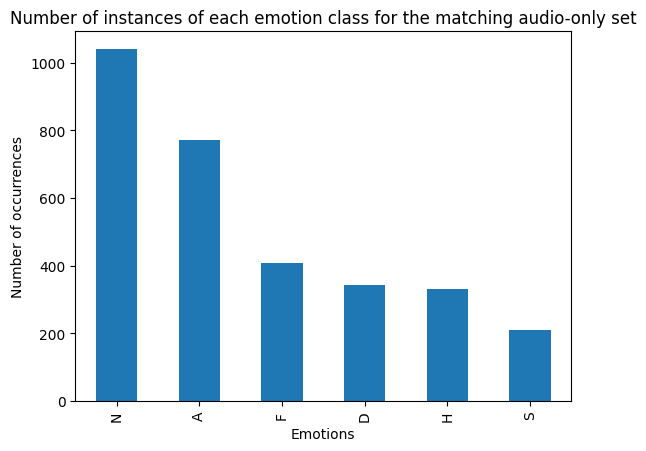

In [33]:
combined_voice_votes_correct.intendedEmo.value_counts().plot(kind="bar", xlabel="Emotions", ylabel="Number of occurrences", title="Number of instances of each emotion class for the matching audio-only set")

In [28]:
combined_voice_votes_incorrect.intendedEmo.value_counts()

S    1062
H     941
D     928
F     864
A     501
N      47
Name: intendedEmo, dtype: int64

<AxesSubplot: title={'center': 'Number of instances of each emotion class for the non-matching audio-only set'}, xlabel='Emotions', ylabel='Number of occurrences'>

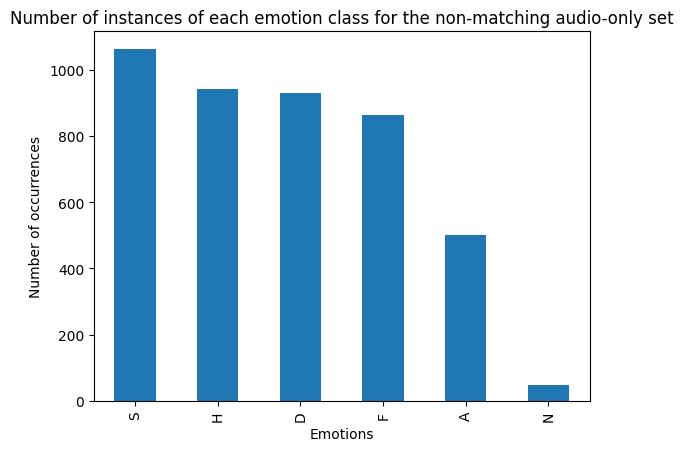

In [34]:
combined_voice_votes_incorrect.intendedEmo.value_counts().plot(kind="bar", xlabel="Emotions", ylabel="Number of occurrences", title="Number of instances of each emotion class for the non-matching audio-only set")

In [29]:
combined_face_votes_correct.intendedEmo.value_counts()

H    1216
N     998
A     831
D     806
F     656
S     424
Name: intendedEmo, dtype: int64

<AxesSubplot: title={'center': 'Number of instances of each emotion class for the matching video-only set'}, xlabel='Emotions', ylabel='Number of occurrences'>

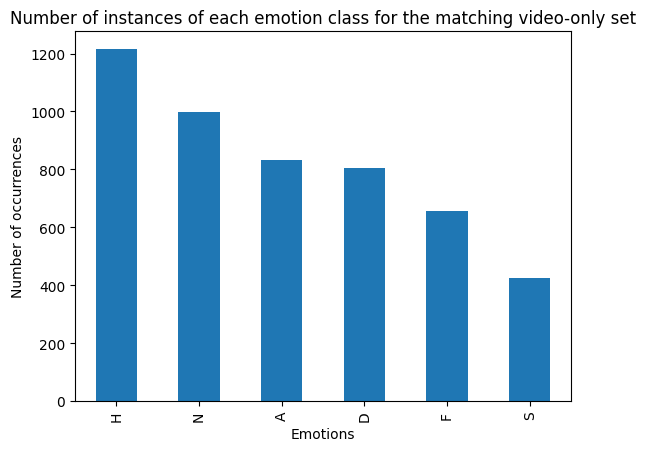

In [35]:
combined_face_votes_correct.intendedEmo.value_counts().plot(kind="bar", xlabel="Emotions", ylabel="Number of occurrences", title="Number of instances of each emotion class for the matching video-only set")

In [30]:
combined_face_votes_incorrect.intendedEmo.value_counts()


S    847
F    615
D    465
A    440
N     89
H     55
Name: intendedEmo, dtype: int64

<AxesSubplot: title={'center': 'Number of instances of each emotion class for the non-matching video-only set'}, xlabel='Emotions', ylabel='Number of occurrences'>

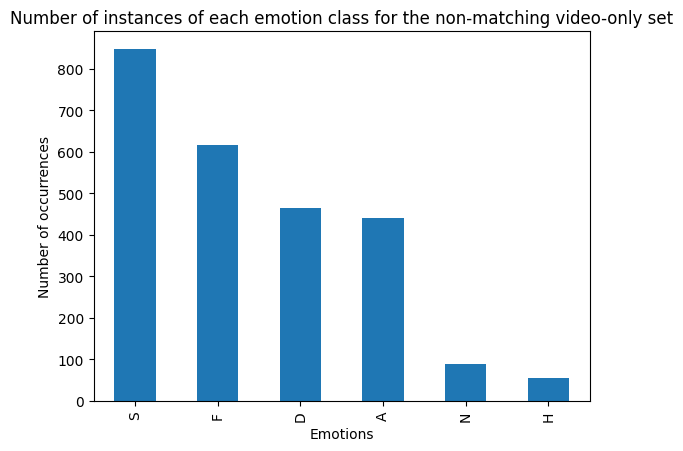

In [36]:
combined_face_votes_incorrect.intendedEmo.value_counts().plot(kind="bar", xlabel="Emotions", ylabel="Number of occurrences", title="Number of instances of each emotion class for the non-matching video-only set")

## Train Test Split

### Plan:
#### Visual:
1. Train/Test split 70/15/15 for matching dataset
2. Random Oversampling
    - Random oversampling to video file names so balanced data can be extracted
    
#### Audio:
1. Train/test split 80/20 for matching dataset
2. SMOTE oversampling

### Audio data split

In [144]:
voice_train, voice_test = train_test_split(combined_voice_votes_correct, test_size=0.2, stratify=combined_voice_votes_correct.intendedEmo, random_state=4)

In [147]:
pd.to_pickle(voice_train, "./audio_tables/voice_train_split_df")
pd.to_pickle(voice_test, "./audio_tables/voice_test_split_df")

In [127]:
voice_train

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo,voiceVote
588,100589,0,5,0,0,0,4,1008_IEO_DIS_HI,9,0.555556,...,55.790186,-1.000000,48.255774,-1.000000,-1.000000,-1.000000,65.208201,58.974359,D,D
3985,103986,0,0,4,0,2,3,1049_ITS_FEA_XX,9,0.444444,...,58.745081,-1.000000,-1.000000,70.706379,-1.000000,40.389272,55.033890,60.439560,F,F
2209,102210,0,4,3,0,2,0,1028_IEO_DIS_MD,9,0.444444,...,34.616499,-1.000000,26.332053,40.242191,-1.000000,42.746855,-1.000000,31.395349,D,D
7439,107440,5,4,0,0,0,0,1091_WSI_ANG_XX,9,0.555556,...,44.634637,28.913787,64.285699,-1.000000,-1.000000,-1.000000,-1.000000,37.681159,A,A
2320,102321,7,0,0,1,0,0,1029_MTI_ANG_XX,8,0.875000,...,82.052019,81.371852,-1.000000,-1.000000,86.813187,-1.000000,-1.000000,84.167518,A,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1132,101133,9,1,0,0,1,0,1014_WSI_ANG_XX,11,0.818182,...,75.064337,74.963612,78.571429,-1.000000,-1.000000,72.463768,-1.000000,78.571429,A,A
883,100884,0,1,0,0,8,2,1011_WSI_NEU_XX,11,0.727273,...,51.277296,-1.000000,0.000000,-1.000000,-1.000000,63.423958,28.329298,51.428571,N,N
2028,102029,8,1,0,0,1,0,1025_WSI_ANG_XX,10,0.800000,...,52.150185,52.803014,86.956522,-1.000000,-1.000000,12.121212,-1.000000,58.007705,A,A
5222,105223,1,4,2,0,1,0,1064_TSI_DIS_XX,8,0.500000,...,41.307659,32.467532,48.717186,26.562500,-1.000000,50.000000,-1.000000,43.750000,D,D


### Visual data split

In [32]:
face_train, face_test = train_test_split(combined_face_votes_correct, test_size=0.3, stratify=combined_face_votes_correct.intendedEmo, random_state=4)
face_val, face_test = train_test_split(face_test, test_size=0.5, stratify=face_test.intendedEmo, random_state=4)

In [33]:
for index in face_train.index:
    if index not in combined_face_votes_correct.index:
        print(index)

In [34]:
y_face_train = face_train.faceVote
y_face_train

7142    N
5286    D
7145    A
5860    D
3072    D
       ..
3032    H
7011    A
5521    N
122     H
2769    N
Name: faceVote, Length: 3451, dtype: object

In [35]:
y_face_test = face_test.faceVote
y_face_test

4786    A
6414    F
1624    H
6984    N
1939    S
       ..
5784    D
2676    H
249     S
1776    A
2027    S
Name: faceVote, Length: 740, dtype: object

In [36]:
y_face_val = face_val.faceVote
y_face_val

7102    N
6241    H
5238    A
5744    H
5199    N
       ..
6143    F
5822    A
1419    F
2544    D
3372    H
Name: faceVote, Length: 740, dtype: object

In [38]:
print(f'Train face size: {face_train.shape[0]},Val face size: {face_val.shape[0]}, Test face size: {face_test.shape[0]}')

Train face size: 3451,Val face size: 740, Test face size: 740


In [39]:
face_train.intendedEmo.value_counts()

H    851
N    698
A    582
D    564
F    459
S    297
Name: intendedEmo, dtype: int64

In [ ]:
face_train.intendedEmo.value_counts().plot(kind="bar", title="Visual Train set", ylable="Count", xlabel="Emotions")

<AxesSubplot: >

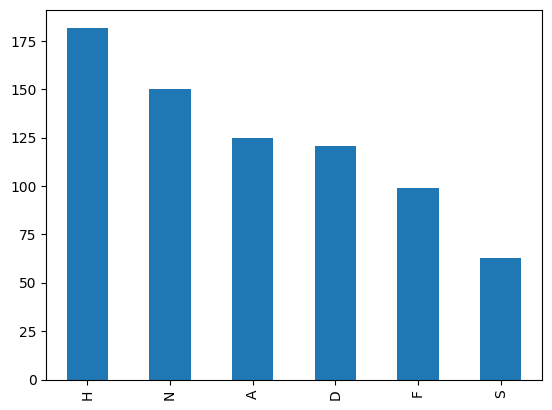

In [41]:
face_val.intendedEmo.value_counts().plot(kind="bar")

<AxesSubplot: >

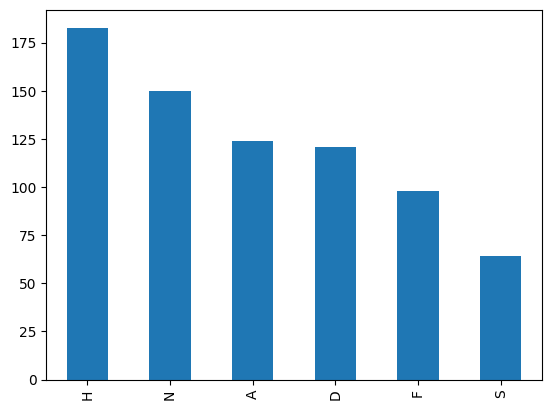

In [42]:
face_test.intendedEmo.value_counts().plot(kind="bar")

## Visual data oversampling

In [43]:
'''
Index will be used to search df before train test split of face data to find file name from index
Useful if index is used as encoding for fileName
'''
def index_to_fileName_train_test_face_votes_correct(index):
    return combined_face_votes_correct.fileName.loc[combined_face_votes_correct.index==index][index]

index_to_fileName_train_test_face_votes_correct(5621)

'1069_ITS_NEU_XX'

In [66]:
combined_face_votes_correct.fileName.loc[combined_face_votes_correct.index==4786]#[4080]

4786    1059_IWL_ANG_XX
Name: fileName, dtype: object

### We want to balance the classes. To do that, use Ranodom oversampler on the 'intendedEmo' class labels. We only need file name for X values because we just need to know which files to repeat

In [45]:
face_train_fname_emo = face_train[["fileName", "intendedEmo"]]
# Convert file name to index
face_train_fname_emo["fileName"] = face_train_fname_emo.index
face_train_fname_emo

/tmp/ipykernel_163388/3277328323.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_train_fname_emo["fileName"] = face_train_fname_emo.index


,fileName,intendedEmo
7142,7142,N
5286,5286,D
7145,7145,A
5860,5860,D
3072,3072,D
...,...,...
3032,3032,H
7011,7011,A
5521,5521,N
122,122,H


In [46]:
labelencoder = LabelEncoder()
face_train_fname_emo["intendedEmo"] = labelencoder.fit_transform(face_train_fname_emo["intendedEmo"])
face_train_fname_emo

/tmp/ipykernel_163388/1742052887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_train_fname_emo["intendedEmo"] = labelencoder.fit_transform(face_train_fname_emo["intendedEmo"])


,fileName,intendedEmo
7142,7142,4
5286,5286,1
7145,7145,0
5860,5860,1
3072,3072,1
...,...,...
3032,3032,3
7011,7011,0
5521,5521,4
122,122,3


### Save labelencoder as pickle

In [47]:
pd.to_pickle(labelencoder, "label_encoder.pkl")

In [48]:
labelencoder = pd.read_pickle("label_encoder.pkl")

In [49]:
face_train_fname_emo

,fileName,intendedEmo
7142,7142,4
5286,5286,1
7145,7145,0
5860,5860,1
3072,3072,1
...,...,...
3032,3032,3
7011,7011,0
5521,5521,4
122,122,3


In [50]:
face_train[["fileName", "intendedEmo"]]

,fileName,intendedEmo
7142,1088_IWW_NEU_XX,N
5286,1065_ITH_DIS_XX,D
7145,1088_IWW_ANG_XX,A
5860,1072_ITH_DIS_XX,D
3072,1038_ITH_DIS_XX,D
...,...,...
3032,1038_TIE_HAP_XX,H
7011,1086_DFA_ANG_XX,A
5521,1068_IWL_NEU_XX,N
122,1002_MTI_HAP_XX,H


In [65]:
# oversample = SMOTE(random_state = 4)
# bal_face_train, y_bal_face_train = oversample.fit_resample(face_train_fname_emo, face_train_fname_emo.intendedEmo)
# # bal_face_train, y_bal_face_train = oversample.fit_resample(face_train[["fileName", "intendedEmo"]], face_train_fname_emo.intendedEmo)

In [59]:
random_oversample = RandomOverSampler(random_state = 4)
bal_face_train, y_bal_face_train = random_oversample.fit_resample(face_train_fname_emo, face_train_fname_emo.intendedEmo)

In [60]:
bal_face_train.intendedEmo.value_counts()

4    851
1    851
0    851
5    851
3    851
2    851
Name: intendedEmo, dtype: int64

In [61]:
bal_face_train

,fileName,intendedEmo
0,7142,4
1,5286,1
2,7145,0
3,5860,1
4,3072,1
...,...,...
5101,2267,5
5102,3145,5
5103,250,5
5104,1885,5


In [62]:
bal_face_train.fileName = bal_face_train.fileName.map(index_to_fileName_train_test_face_votes_correct)
bal_face_train

,fileName,intendedEmo
0,1088_IWW_NEU_XX,4
1,1065_ITH_DIS_XX,1
2,1088_IWW_ANG_XX,0
3,1072_ITH_DIS_XX,1
4,1038_ITH_DIS_XX,1
...,...,...
5101,1028_TSI_SAD_XX,5
5102,1039_IWL_SAD_XX,5
5103,1004_IEO_SAD_MD,5
5104,1024_TIE_SAD_XX,5


In [63]:
pd.to_pickle(bal_face_train, "balanced_face_train.pkl")

In [74]:
face_val_fname_emo = face_val[["fileName", "intendedEmo"]]
# Convert file name to index
face_val_fname_emo["fileName"] = face_val_fname_emo.index
face_val_fname_emo

/tmp/ipykernel_163388/434872858.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_val_fname_emo["fileName"] = face_val_fname_emo.index


,fileName,intendedEmo
7102,7102,N
6241,6241,H
5238,5238,A
5744,5744,H
5199,5199,N
...,...,...
6143,6143,F
5822,5822,A
1419,1419,F
2544,2544,D


In [75]:
face_val_fname_emo["intendedEmo"] = labelencoder.fit_transform(face_val_fname_emo["intendedEmo"])
face_val_fname_emo

/tmp/ipykernel_163388/285420519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_val_fname_emo["intendedEmo"] = labelencoder.fit_transform(face_val_fname_emo["intendedEmo"])


,fileName,intendedEmo
7102,7102,4
6241,6241,3
5238,5238,0
5744,5744,3
5199,5199,4
...,...,...
6143,6143,2
5822,5822,0
1419,1419,2
2544,2544,1


In [79]:
face_val_fname_emo.reset_index(drop=True,inplace=True)
face_val_fname_emo

,fileName,intendedEmo
0,7102,4
1,6241,3
2,5238,0
3,5744,3
4,5199,4
...,...,...
735,6143,2
736,5822,0
737,1419,2
738,2544,1


In [95]:
face_val_fname_emo.fileName = face_val_fname_emo.fileName.map(index_to_fileName_train_test_face_votes_correct)
face_val_fname_emo

/tmp/ipykernel_163388/1403087743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_val_fname_emo.fileName = face_val_fname_emo.fileName.map(index_to_fileName_train_test_face_votes_correct)


,fileName,intendedEmo
0,1087_TSI_NEU_XX,4
1,1077_IWW_HAP_XX,3
2,1065_IEO_ANG_HI,0
3,1071_IOM_HAP_XX,3
4,1064_ITH_NEU_XX,4
...,...,...
735,1076_IEO_FEA_HI,2
736,1072_TIE_ANG_XX,0
737,1018_TAI_FEA_XX,2
738,1032_TIE_DIS_XX,1


In [96]:
pd.to_pickle(face_val_fname_emo, "face_val.pkl")

In [81]:
face_test_fname_emo = face_val[["fileName", "intendedEmo"]]
# Convert file name to index
face_test_fname_emo["fileName"] = face_test_fname_emo.index
face_test_fname_emo

/tmp/ipykernel_163388/674262117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_test_fname_emo["fileName"] = face_test_fname_emo.index


,fileName,intendedEmo
7102,7102,N
6241,6241,H
5238,5238,A
5744,5744,H
5199,5199,N
...,...,...
6143,6143,F
5822,5822,A
1419,1419,F
2544,2544,D


In [82]:
face_test_fname_emo["intendedEmo"] = labelencoder.fit_transform(face_test_fname_emo["intendedEmo"])
face_test_fname_emo.reset_index(drop=True,inplace=True)
face_test_fname_emo

/tmp/ipykernel_163388/1044226819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_test_fname_emo["intendedEmo"] = labelencoder.fit_transform(face_test_fname_emo["intendedEmo"])


,fileName,intendedEmo
0,7102,4
1,6241,3
2,5238,0
3,5744,3
4,5199,4
...,...,...
735,6143,2
736,5822,0
737,1419,2
738,2544,1


In [102]:
face_test_fname_emo.fileName = face_test_fname_emo.fileName.map(index_to_fileName_train_test_face_votes_correct)
face_test_fname_emo

/tmp/ipykernel_163388/3050394118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  face_test_fname_emo.fileName = face_test_fname_emo.fileName.map(index_to_fileName_train_test_face_votes_correct)


,fileName,intendedEmo
0,1087_TSI_NEU_XX,4
1,1077_IWW_HAP_XX,3
2,1065_IEO_ANG_HI,0
3,1071_IOM_HAP_XX,3
4,1064_ITH_NEU_XX,4
...,...,...
735,1076_IEO_FEA_HI,2
736,1072_TIE_ANG_XX,0
737,1018_TAI_FEA_XX,2
738,1032_TIE_DIS_XX,1


In [103]:
pd.to_pickle(face_test_fname_emo, "face_test.pkl")

<AxesSubplot: >

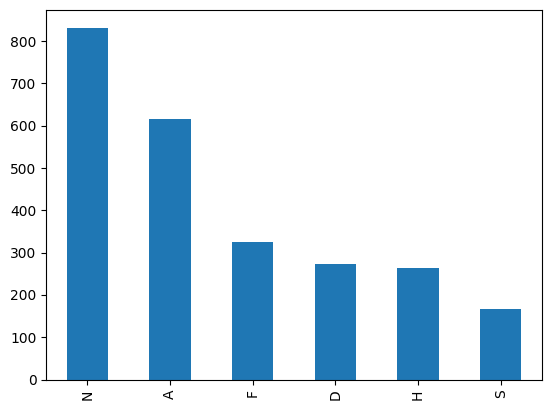

In [10]:
voice_train = pd.read_pickle("./audio_tables/voice_train_split_df")
voice_train.intendedEmo.value_counts().plot(kind="bar")

<AxesSubplot: >

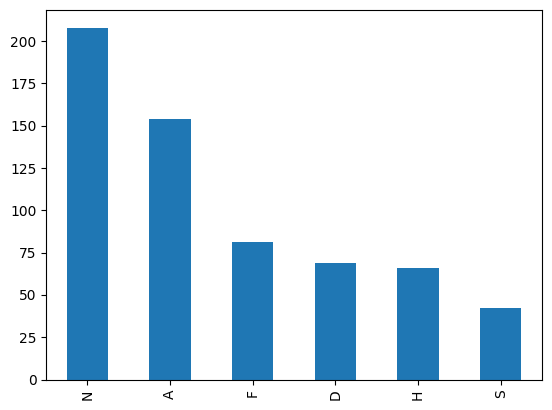

In [2]:
voice_test = pd.read_pickle("./audio_tables/voice_test_split_df")
voice_test.intendedEmo.value_counts().plot(kind="bar")

In [3]:
voice_test

,Unnamed: 0,A,D,F,H,N,S,fileName,numResponses,agreement,...,meanEmoRespNorm,meanAngerRespNorm,meanDisgustRespNorm,meanFearRespNorm,meanHappyRespNorm,meanNeutralRespNorm,meanSadRespNorm,medianEmoRespNorm,intendedEmo,voiceVote
510,100511,7,3,1,0,0,0,1007_TIE_ANG_XX,11,0.636364,...,66.459258,67.969524,61.228740,71.578947,-1.000000,-1.000000,-1.00000,72.000000,A,A
1548,101549,4,1,2,2,0,0,1020_IEO_ANG_HI,9,0.444444,...,45.898671,58.552503,28.409091,54.027778,21.206691,-1.000000,-1.00000,42.500000,A,A
401,100402,0,1,8,0,0,0,1005_TSI_FEA_XX,9,0.888889,...,45.689876,-1.000000,1.204819,51.250508,-1.000000,-1.000000,-1.00000,50.000000,F,F
349,100350,1,0,0,0,9,0,1005_IOM_NEU_XX,10,0.900000,...,64.370918,38.043478,-1.000000,-1.000000,-1.000000,67.296189,-1.00000,61.709770,N,N
3963,103964,0,2,1,0,6,0,1049_IWL_NEU_XX,9,0.666667,...,50.555939,-1.000000,26.344086,29.629630,-1.000000,62.114275,-1.00000,52.688172,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,104244,0,1,5,0,2,1,1052_WSI_FEA_XX,9,0.555556,...,33.552115,-1.000000,20.634921,41.976336,-1.000000,18.464314,34.52381,27.835052,F,F
5994,105995,1,5,0,0,3,0,1074_IOM_DIS_XX,9,0.555556,...,40.385711,10.204082,35.211905,-1.000000,-1.000000,59.069264,-1.00000,45.714286,D,D
277,100278,1,1,5,0,3,0,1004_IWW_FEA_XX,10,0.500000,...,34.494925,77.777778,31.395349,33.931731,-1.000000,22.039156,-1.00000,30.849190,F,F
1114,101115,8,0,0,0,1,0,1014_DFA_ANG_XX,9,0.888889,...,58.026839,65.280194,-1.000000,-1.000000,-1.000000,0.000000,-1.00000,67.924528,A,A
